## Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare 1D convolutional networks with and without didilation rate and LSTMs. We predict the time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the long term dependencies of the time series.

In [0]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

import keras 
from keras.models import Sequential
from keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN


Using TensorFlow backend.


### Simulate some data

In the next cell we generate train and validation data. We multiply a fast sine wave with a slower sine wave and add a bit random noise. The goal is to learn from the past of time series and predict the next 10 steps and later even more than "only"  10 steps.


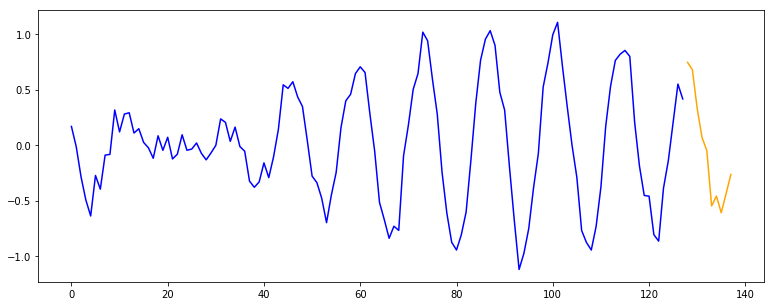

The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.


In [0]:
np.random.seed(1) # Fixing the seed, so data generation is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1,seq_length=128,look_ahead=10): # We create 1000 observations of the process
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(1):
  plt.figure(num=None, figsize=(13,5))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'b-',color='orange')

plt.show()
print('The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.')

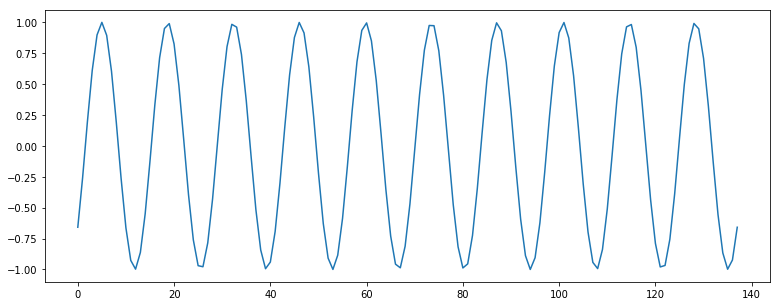

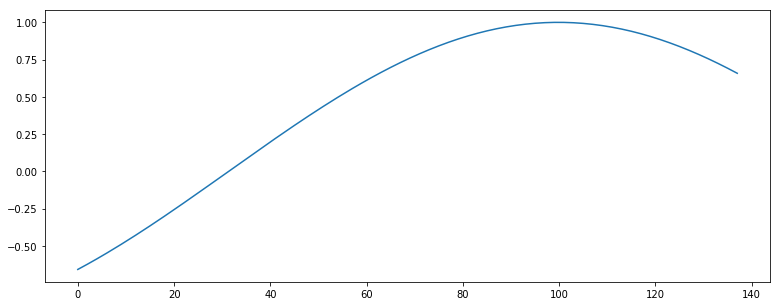

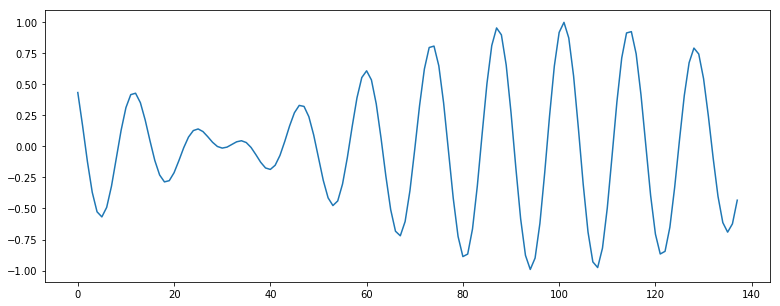

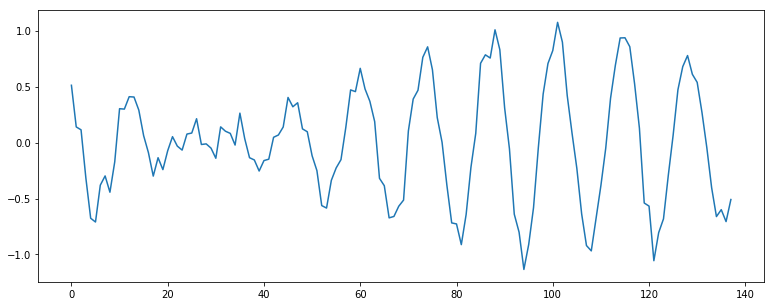

In [0]:
# process:fast sine wave * slow sine wave + random noise
start = np.random.uniform(0, 2*np.pi) # Random start point
s=128+10
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s))+np.random.normal(0,0.1,s))
plt.show()


In [0]:
print(X.shape)
print(Y.shape)

(1000, 128, 1)
(1000, 10, 1)


### 1D Convolution without dilation rate

Here we define a Neural network with 1D convolutions and "causal" padding, in a later step we will also use a dilation rate.

In [0]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]
  
model_1Dconv = Sequential()
ks = 5
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', input_shape=(128, 1)))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_1Dconv.add(Dense(1))
model_1Dconv.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_1Dconv.compile(optimizer='adam', loss='mean_squared_error')
model_1Dconv.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 32)           192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
dense_1 (Dense)              (None, 128, 1)            33        
_________________________________________________________________
lambda_1 (Lambda)            (None, 10, 1)             0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0


In [0]:
history = model_1Dconv.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 1s 2ms/step - loss: 0.1239 - val_loss: 0.0495
Epoch 2/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0481 - val_loss: 0.0509
Epoch 3/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0410 - val_loss: 0.0393
Epoch 4/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0372 - val_loss: 0.0301
Epoch 5/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0346 - val_loss: 0.0282
Epoch 6/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0316 - val_loss: 0.0287
Epoch 7/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0301 - val_loss: 0.0264
Epoch 8/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0286 - val_loss: 0.0262
Epoch 9/100
800/800 [==============================] - 1s 972us/step - loss: 0.0278 - val_loss: 0.

800/800 [==============================] - 1s 1ms/step - loss: 0.0240 - val_loss: 0.0226
Epoch 79/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0238 - val_loss: 0.0220
Epoch 80/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0236 - val_loss: 0.0236
Epoch 81/100
800/800 [==============================] - 1s 875us/step - loss: 0.0243 - val_loss: 0.0223
Epoch 82/100
800/800 [==============================] - 1s 831us/step - loss: 0.0237 - val_loss: 0.0223
Epoch 83/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0240 - val_loss: 0.0218
Epoch 84/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0237 - val_loss: 0.0221
Epoch 85/100
800/800 [==============================] - 1s 981us/step - loss: 0.0238 - val_loss: 0.0225
Epoch 86/100
800/800 [==============================] - 1s 963us/step - loss: 0.0243 - val_loss: 0.0221
Epoch 87/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0243 - va

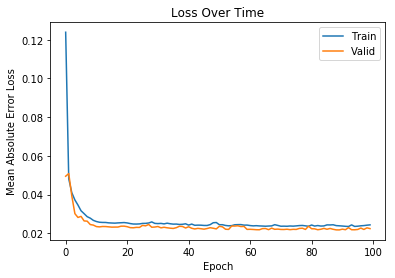

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

Now we want to use the trained model to predict for the next 10 steps, remember that is what the model was trained on.  
In addition,  we want to predict for longer than just 10 steps, we will  just predict the next 10 steps and take the predictions as new "true" observations and feed these values into the model, when we do that we can predict for any length we want. In the next cell we will predict the next 10 and 80 steps.

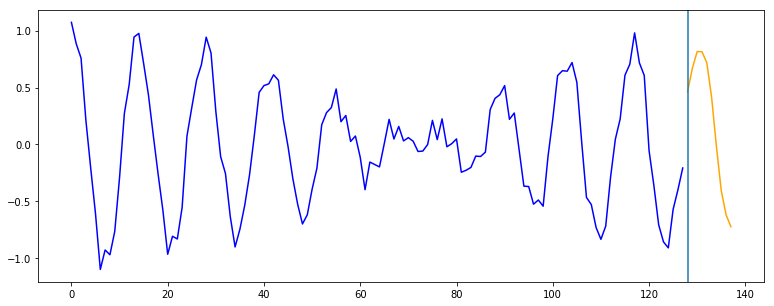

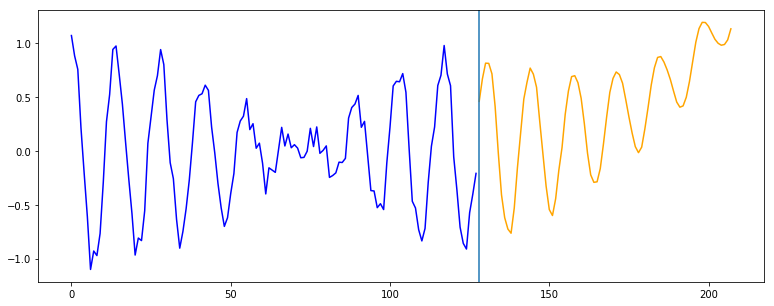

In [0]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time.

In [0]:
model_1Dconv_w_d = Sequential()
ks = 5
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1, input_shape=(128, 1)))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
model_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))
model_1Dconv_w_d.add(Dense(1))
model_1Dconv_w_d.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_1Dconv_w_d.compile(optimizer='adam', loss='mean_squared_error')
model_1Dconv_w_d.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 128, 32)           192       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
dense_2 (Dense)              (None, 128, 1)            33        
_________________________________________________________________
lambda_2 (Lambda)            (None, 10, 1)             0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_1Dconv_w_d.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 2s 2ms/step - loss: 0.1806 - val_loss: 0.0601
Epoch 2/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0493 - val_loss: 0.0292
Epoch 3/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0276 - val_loss: 0.0173
Epoch 4/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0166 - val_loss: 0.0181
Epoch 5/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0170 - val_loss: 0.0135
Epoch 6/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 7/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 8/100
800/800 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 9/100
800/800 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0119
Epoch 10/100
800/800 [=======================

Epoch 81/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 82/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 83/100
800/800 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 84/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 85/100
800/800 [==============================] - 1s 2ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 86/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 87/100
800/800 [==============================] - 2s 2ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 88/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 89/100
800/800 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 90/100
800/800 [==============================] - 1s 2ms/step - loss: 0.0120

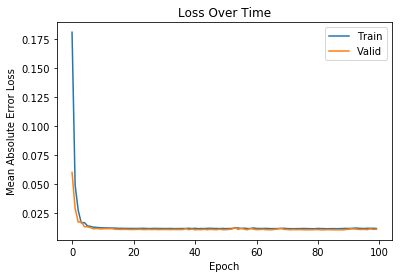

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

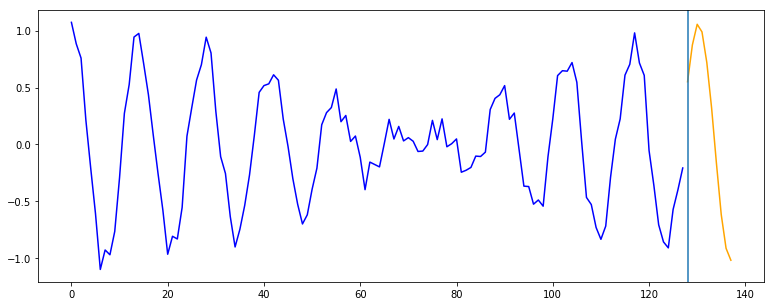

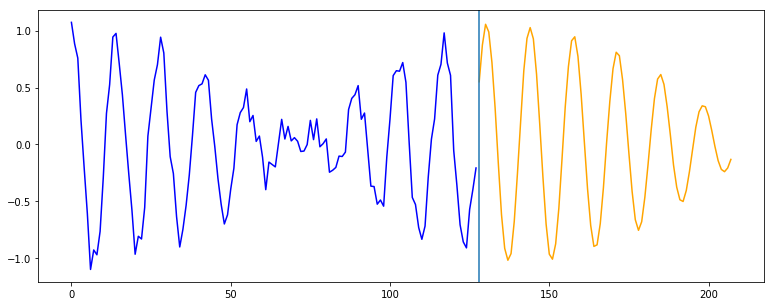

In [0]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### Simple RNN

Now, let's use a RNN cell to see if we are able to learn the data generating process. We will use a hidden state size of 12.

In [0]:
model_simple_RNN = Sequential()

model_simple_RNN.add(SimpleRNN(12,return_sequences=True,input_shape=(128,1)))
model_simple_RNN.add((Dense(1)))
model_simple_RNN.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_simple_RNN.summary()
model_simple_RNN.compile(optimizer='adam', loss='mean_squared_error')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128, 12)           168       
_________________________________________________________________
dense_3 (Dense)              (None, 128, 1)            13        
_________________________________________________________________
lambda_3 (Lambda)            (None, 10, 1)             0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_simple_RNN.fit(X[0:800], Y[0:800],
                    epochs=500,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=0)

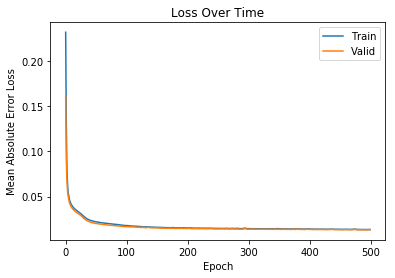

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

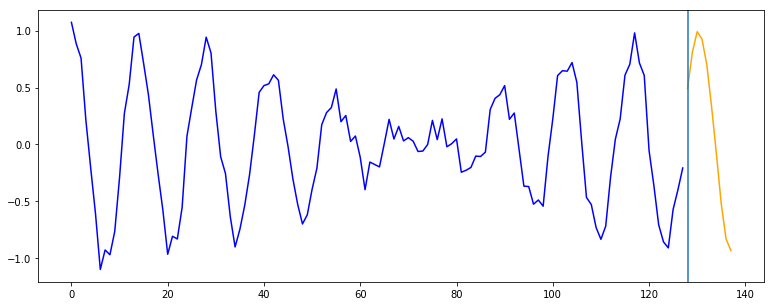

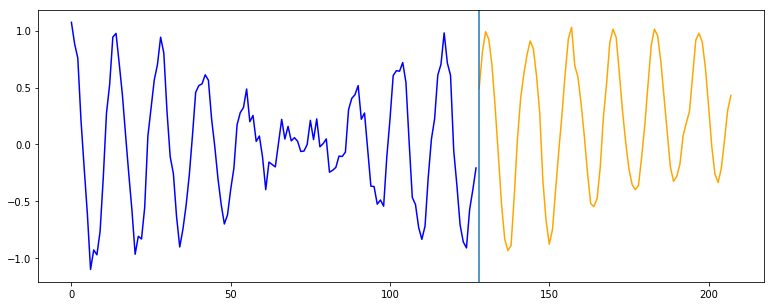

In [0]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_RNN

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_RNN

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### LSTM Cell

Let's use a more complex LSTM cell to and see if it works better than the RNN cell,  we again use a hidden state size of 12.

In [0]:
model_LSTM = Sequential()

model_LSTM.add(LSTM(12,return_sequences=True,input_shape=(128,1)))
model_LSTM.add((Dense(1)))
model_LSTM.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_LSTM.summary()
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 12)           672       
_________________________________________________________________
dense_4 (Dense)              (None, 128, 1)            13        
_________________________________________________________________
lambda_4 (Lambda)            (None, 10, 1)             0         
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


#### To train the LSTM model takes some time, so we just load a trained model after 500 epochs

In [0]:
#history = model_LSTM.fit(X[0:800], Y[0:800],
#                    epochs=500,
#                    batch_size=128,
#                    validation_data=(X[800:1000],Y[800:1000]),
#                    verbose=0)

In [0]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#
#plt.xlabel('Epoch')
#plt.ylabel('Mean Absolute Error Loss')
#plt.title('Loss Over Time')
#plt.legend(['Train','Valid'])

In [0]:
#model_LSTM.save('../data/models/lstm_model_500_epochs.hdf5')  

In [0]:
# we load the trained lstm model 
from keras.models import load_model
model_LSTM = load_model('../data/models/lstm_model_500_epochs.hdf5')
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 12)           672       
_________________________________________________________________
dense_4 (Dense)              (None, 128, 1)            13        
_________________________________________________________________
lambda_4 (Lambda)            (None, 10, 1)             0         
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_LSTM.evaluate(X[0:800], Y[0:800])

800/800 [==============================] - 1s 1ms/step


0.011688415929675101

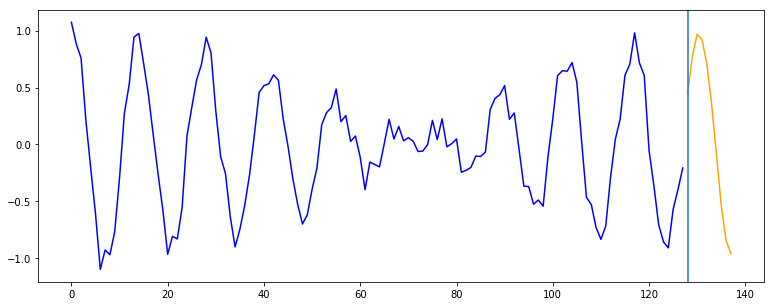

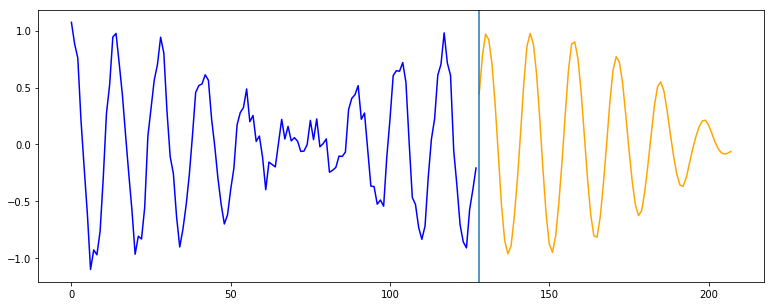

In [0]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_LSTM

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_LSTM

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### Compare all models for very long predictions (800 timesteps)

Text(0.5, 1.0, 'model_LSTM')

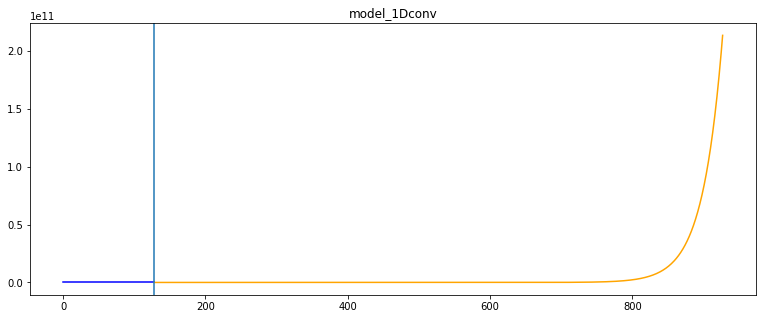

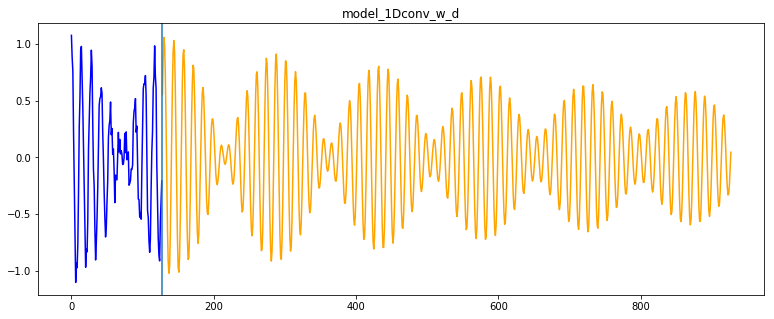

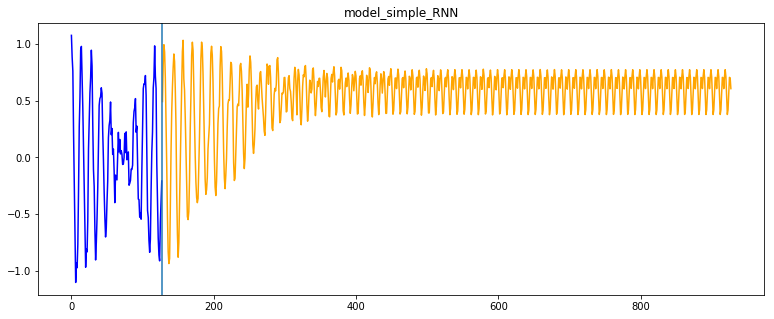

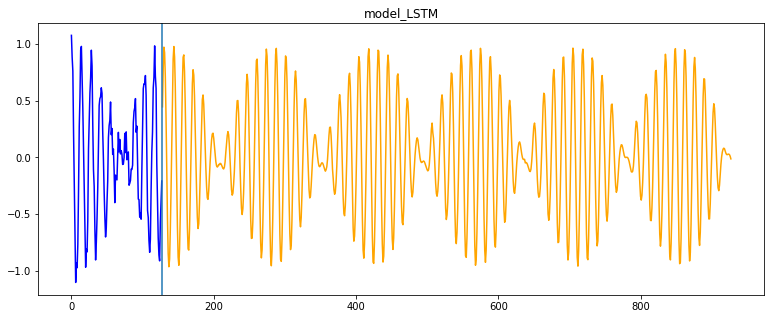

In [0]:
i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
plt.title("model_1Dconv")

i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
plt.title("model_1Dconv_w_d")

i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_RNN

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
plt.title("model_simple_RNN")

i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_LSTM

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
plt.title("model_LSTM")
